# Logging simulation results

This short example shows how you can select different variables to log during a simulation.

For this example we've used [a model of the human atrial AP](https://doi.org/10.1161/CIRCRESAHA.111.253955) by Grandi et al. You can download a copy of the model here: [grandi-2011.mmt](models/grandi-2011.mmt).

## Specifying variables by name

We start by loading the [model](https://myokit.readthedocs.io/api_core/Model.html) and its associated pacing [protocol](https://myokit.readthedocs.io/api_simulations/Protocol.html) and using them to create and run a [simulation](https://myokit.readthedocs.io/api_simulations/Simulation.html):

In [12]:
import myokit

# Load a model, protocol, and script from an mmt file
model, protocol, script = myokit.load('models/grandi-2011.mmt')

# Create a simulation
sim = myokit.Simulation(model, protocol)

# Run it
log1 = sim.run(700)

Now we can take a look at the model code, and find some variables we'd like to plot, for example `membrane.V`, `ical.ICaL` and `ikur.IKur`:

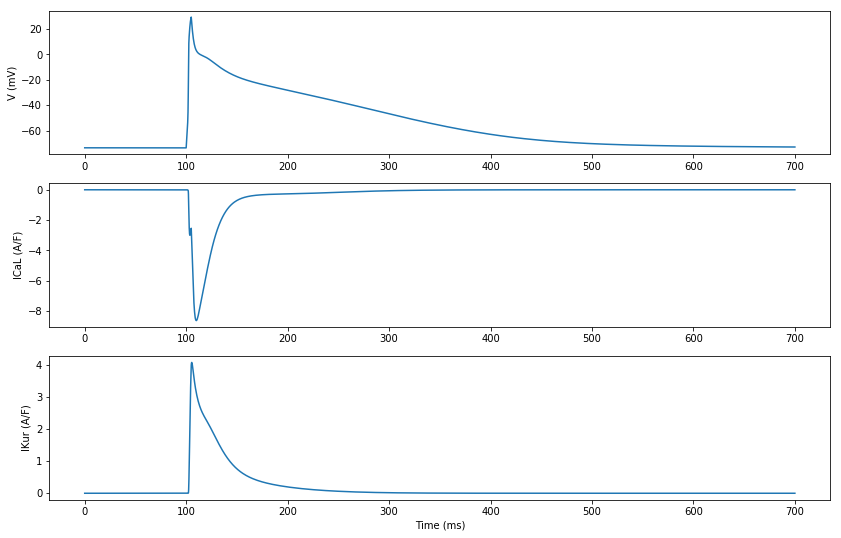

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 9))
plt.subplot(3, 1, 1)
plt.ylabel('V (mV)')
plt.plot(log1['engine.time'], log1['membrane.V'])
plt.subplot(3, 1, 2)
plt.ylabel('ICaL (A/F)')
plt.plot(log1['engine.time'], log1['ical.ICaL'])
plt.subplot(3, 1, 3)
plt.xlabel('Time (ms)')
plt.ylabel('IKur (A/F)')
plt.plot(log1['engine.time'], log1['ikur.IKur'])
plt.show()

If we know in advance that we only want to plot these variables, we can specify this before running the simulation:

In [3]:
sim.reset()
log2 = sim.run(700, log=['engine.time', 'membrane.V', 'ical.ICaL', 'ikur.IKur'])

This will make the simulation log a lot smaller:

In [4]:
print('Old log size: ' + str(len(log1)))
print('New log size: ' + str(len(log2)))

Old log size: 203
New log size: 4


This saves a bit of memory, but can also save some time:

In [5]:
b = myokit.Benchmarker()
sim.reset()
sim.run(10 * 1000)
print('With all variables: ' + str(b.time()) + ' seconds')
b.reset()
sim.reset()
sim.run(10 * 1000, log=['engine.time', 'membrane.V', 'ical.ICaL', 'ikur.IKur'])
print('With four variables: ' + str(b.time()) + ' seconds')
b.reset()
sim.reset()
sim.run(10 * 1000, log=[])
print('With zero variables: ' + str(b.time()) + ' seconds')

With all variables: 0.24778150900056062 seconds
With four variables: 0.09739472299952467 seconds
With zero variables: 0.0803944870003761 seconds


## Logging derivatives

Derivatives of state variables can also be logged.
These are specified using the syntax `dot(x)`, where `x` is the name of the state variable:

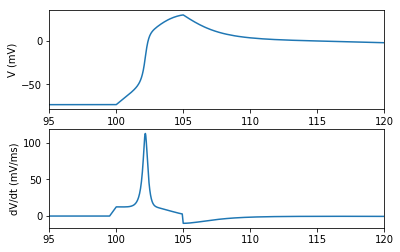

In [6]:
sim.reset()
log = sim.run(200, log=['engine.time', 'membrane.V', 'dot(membrane.V)'])

plt.figure()
plt.subplot(2, 1, 1)
plt.xlim(95, 120)
plt.ylabel('V (mV)')
plt.plot(log['engine.time'], log['membrane.V'])
plt.subplot(2, 1, 2)
plt.xlim(95, 120)
plt.ylabel('dV/dt (mV/ms)')
plt.plot(log['engine.time'], log['dot(membrane.V)'])
plt.show()

## Using logging flags

In addition to specifying variables by name, we can use integer 'flags' to specify groups of variables.
For example, to log only state variables, use the `LOG_STATE` flag:

In [14]:
sim.reset()
log = sim.run(1000, log=myokit.LOG_STATE)

print(model.count_states())
print(len(log))

41
41


Typically, we'll also want to log time though, which we can achieve with:

In [15]:
sim.reset()
log = sim.run(600, log=myokit.LOG_STATE + myokit.LOG_BOUND)

print(model.count_states())
print(len(log))

41
43


The `LOG_BOUND` flag tells the simulator to log any variable "bound" to external inputs: in this case the time variable and the variable that's used to create a pacing signal. These variables are called "bound variables in Myokit (see [here](https://myokit.readthedocs.io/syntax/model.html#interfacing-with-the-outside-world)).

What about currents?
These are not state variables or bound variables.
From a mathematical point of view, they are simply part of the equations to calculate the state variable derivatives.
In Myokit we call any such variable an "intermediate variable", and we can log all intermediate variables using `LOG_INTER`:

In [16]:
sim.reset()
log = sim.run(600, log=myokit.LOG_INTER + myokit.LOG_BOUND)

print(len(log))

121


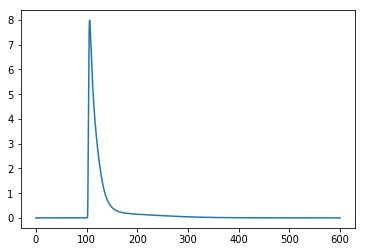

In [17]:
plt.figure()
plt.plot(log['engine.time'], log['ito.Ito'])
plt.show()

The full list of flags is given [here](https://myokit.readthedocs.io/api_simulations/DataLog.html#myokit.prepare_log).

## Continuing a previous simulation

A final option for the `log` argument is to pass in an existing simulation log. In this case, the newly logged entries will be appended to the ones already in the log.

Let's run the first 150ms of a simulation:

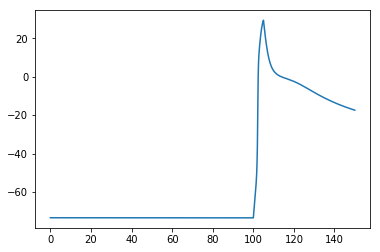

Exception: Call to append() failed on logging list.

In [18]:
sim.reset()

log = sim.run(150)

plt.figure()
plt.plot(log.time(), log['membrane.V'])
plt.show()

log = sim.run(450, log=log)

#plt.figure()
#plt.plot(d.time(), d['membrane.V'])
#plt.show()

Now we pass in the previous log, and continue our simulation

In [ ]:
d = sim.run(450, log=d)

#plt.figure()
#plt.plot(d.time(), d['membrane.V'])
#plt.show()

This can be particularly useful when you want to make changes during a simulation.